## Autoencoder deep ou stack

Pode ser representado pela figura a seguir:

![](deep_autoencoder.png)

O objetivo desse exemplo é fazer o autoencoder com as imagens do MNIST.

Estamos utilizando o banco de imagens de números que é obtido pelo link: http://yann.lecun.com/exdb/mnist/.



In [15]:
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [8]:
# Lendo as imagens e fazendo download
mnist = input_data.read_data_sets('mnist/', # As imagens ficarão nesse diretório 
                                  one_hot = True) # Faz a categorização "binária" de múltiplas classes

Extracting mnist/train-images-idx3-ubyte.gz
Extracting mnist/train-labels-idx1-ubyte.gz
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz


In [9]:
# Separando os dados em treino e teste
X_train = mnist.train.images
Y_train = mnist.train.labels
X_test  = mnist.test.images
Y_test  = mnist.test.labels

# Analisando as dimensões
print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)
print("Y_train: ", Y_train.shape)
print("Y_test: ", Y_test.shape)

X_train:  (55000, 784)
X_test:  (10000, 784)
Y_train:  (55000, 10)
Y_test:  (10000, 10)


Text(0.5, 1.0, 'Classe: 3')

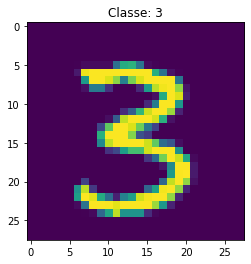

In [13]:
# Agora vamos observar de fato alguma imagem carregada
%matplotlib inline
indice = 102
plt.imshow(X_train[indice].reshape((28,28))) 
plt.title('Classe: ' + str(np.argmax(Y_train[indice])))

Temos que a dimensão da imagem é 28 * 28 = 784. E o objetivo é reduzir de 784 para 64.

Iremos ver o seguinte fluxo:

784 -> 128 -> 64 -> 128 -> 784

In [17]:
# Iremos ter as seguintes camadas
neuronios_entrada = 784                # encoder
neuronios_oculta1 = 128                # encoder
neuronios_oculta2 = 64                 # dado/imagem codificada
neuronios_oculta3 = neuronios_oculta1  # decoder
neuronios_saida = neuronios_entrada    # decoder

In [18]:
tf.reset_default_graph() # limpa a memória

# Criando o placeholder
xph = tf.placeholder(tf.float32, [None, neuronios_entrada])

In [19]:
# Antes estavamos realizandoa inicialização dos pesos de maneira randomica com distribuição normal
# Mas nesse caso, vamos inicializar os pesos com a inicialização Xavier 
# Nela a escala dos pesos se mantem a mesma em todas as camadas. (como se fosse uma padronização)

# A inicialização Xavier se adapta melhor na função Sigmóide
# A inicialização He se adapta melhor na função RELU

inicializador = tf.variance_scaling_initializer()

In [20]:
# Fluxo das camadas: 784 -> 128 -> 64 -> 128 -> 784
# Vamos criar um dicionário de pesos com a inicialização personalizada
W = {'encoder_oculta1': tf.Variable(inicializador([neuronios_entrada, neuronios_oculta1])),
     'encoder_oculta2': tf.Variable(inicializador([neuronios_oculta1, neuronios_oculta2])),
     'decoder_oculta3': tf.Variable(inicializador([neuronios_oculta2, neuronios_oculta3])),
     'decoder_saida': tf.Variable(inicializador([neuronios_oculta3, neuronios_saida]))
}

# Vamos criar um dicionário do bias com a inicialização personalizada
b = {'encoder_oculta1': tf.Variable(inicializador([neuronios_oculta1])),
     'encoder_oculta2': tf.Variable(inicializador([neuronios_oculta2])),
     'decoder_oculta3': tf.Variable(inicializador([neuronios_oculta3])),
     'decoder_saida': tf.Variable(inicializador([neuronios_saida]))
}

Instructions for updating:
Colocations handled automatically by placer.


In [21]:
# Aqui vamos aplicar a função de ativação RELU. 

# Na camada_oculta1 multiplicamos a entrada com os pesos e depois somamos o bias
camada_oculta1 = tf.nn.relu(tf.add(tf.matmul(xph, W['encoder_oculta1']), 
                                   b['encoder_oculta1']))
camada_oculta2 = tf.nn.relu(tf.add(tf.matmul(camada_oculta1, W['encoder_oculta2']), b['encoder_oculta2']))
camada_oculta3 = tf.nn.relu(tf.add(tf.matmul(camada_oculta2, W['decoder_oculta3']), b['decoder_oculta3']))
camada_saida = tf.nn.relu(tf.add(tf.matmul(camada_oculta3, W['decoder_saida']), b['decoder_saida']))

In [22]:
# Vamos calcular o erro agora
erro = tf.losses.mean_squared_error(xph, camada_saida) # Comparamos a entrada de entrada com a entrada de saída
otimizador = tf.train.AdamOptimizer(learning_rate = 0.001)
treinamento = otimizador.minimize(erro) # minimizando o erro
batch_size = 128

Instructions for updating:
Use tf.cast instead.


In [24]:
# Vamos realizar os cálculos de fato
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    # Treinando
    for epoca in range(50):
        
        # Aqui teremos a quantidade total de partes que terão que ser executadas para que todo o conjunto seja processado
        numero_batches = mnist.train.num_examples // batch_size # dividindo
        
        # Percorrendo o conjunto através do batch_size
        for i in range(numero_batches):
            X_batch, _ = mnist.train.next_batch(batch_size) # pega os próximos 128 (batch_size) registros 
            custo, _ = sess.run([erro, treinamento], feed_dict = {xph: X_batch})
        print('época: ' + str(epoca + 1) + ' erro: ' + str(custo))
    
    # Podemos notar que a camada_oculta2 obtem a imagem codificada, onde a imagem tem dimensão de 64 pixels
    imagens_codificadas = sess.run(camada_oculta2, feed_dict = {xph: X_train})
    
     # Podemos notar que a camada_saida obtem a imagem decodificada, onde a imagem volta a ter dimensão de 784 pixels
    imagens_decodificadas = sess.run(camada_saida, feed_dict = {xph: X_train})

época: 1 erro: 0.016510239
época: 2 erro: 0.014312896
época: 3 erro: 0.012611919
época: 4 erro: 0.011183261
época: 5 erro: 0.01177516
época: 6 erro: 0.010998884
época: 7 erro: 0.011862601
época: 8 erro: 0.011090107
época: 9 erro: 0.00964152
época: 10 erro: 0.0101589495
época: 11 erro: 0.01033935
época: 12 erro: 0.009558565
época: 13 erro: 0.010899072
época: 14 erro: 0.010020057
época: 15 erro: 0.010521714
época: 16 erro: 0.010262264
época: 17 erro: 0.009499461
época: 18 erro: 0.010434569
época: 19 erro: 0.009455113
época: 20 erro: 0.00948534
época: 21 erro: 0.009449255
época: 22 erro: 0.009185976
época: 23 erro: 0.009482498
época: 24 erro: 0.009639491
época: 25 erro: 0.009886271
época: 26 erro: 0.009366791
época: 27 erro: 0.009396274
época: 28 erro: 0.009399173
época: 29 erro: 0.010091106
época: 30 erro: 0.0094408365
época: 31 erro: 0.010272798
época: 32 erro: 0.0086014625
época: 33 erro: 0.009641527
época: 34 erro: 0.008952009
época: 35 erro: 0.009212772
época: 36 erro: 0.01003423
épo

In [25]:
# Agora vamos analisar as dimensões das imagens
print("\nDimensões das imagens codificadas: ", imagens_codificadas.shape)
print("\nDimensões das imagens decodificadas: ", imagens_decodificadas.shape)


Dimensões das imagens codificadas:  (55000, 64)

Dimensões das imagens decodificadas:  (55000, 784)


In [27]:
imagens_codificadas[0]

array([1.4483604 , 1.6491432 , 0.83055615, 0.9942977 , 0.        ,
       1.8103863 , 0.        , 0.        , 1.3380204 , 0.5795993 ,
       0.        , 1.5924578 , 0.        , 0.        , 0.60291237,
       1.5162032 , 1.5713091 , 1.4433053 , 1.6133239 , 0.9183895 ,
       0.07707021, 1.3627462 , 1.1349121 , 0.        , 0.        ,
       1.952907  , 1.858273  , 1.760317  , 0.5923939 , 0.        ,
       0.8124427 , 0.46701398, 2.2822554 , 0.36426398, 0.7010705 ,
       1.4729869 , 1.4447739 , 0.3809383 , 0.        , 1.8010628 ,
       0.        , 0.89919585, 0.13295177, 0.        , 0.        ,
       2.1232073 , 1.0488913 , 0.        , 1.3293691 , 1.046704  ,
       1.4396479 , 0.6452067 , 1.5528142 , 2.192408  , 1.033908  ,
       1.0494545 , 1.0996267 , 1.3387923 , 1.66226   , 0.        ,
       0.        , 1.6910465 , 1.8297286 , 0.77908766], dtype=float32)

In [28]:
imagens_decodificadas[0]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [26]:
# Vamos ver as imagens codificadas e as imagens originais
numero_imagens = 5 # escolhemos visualizar 5 imagens
imagens_teste = np.random.randint(X_train.shape[0], size = numero_imagens) # Obtem 5 imagens aleatórias do conjunto

print("Indices das imagens que vamos visualizar: ", imagens_teste)

[53704 48116 31966 30335  9321]


In [29]:
print("Testando... \n")
for i, indice_imagem in enumerate(imagens_teste):
    print("\ni: ", i)
    print("\nIndice da imagem: ", indice_imagem)
    

Testando... 


i:  0

Indice da imagem:  53704

i:  1

Indice da imagem:  48116

i:  2

Indice da imagem:  31966

i:  3

Indice da imagem:  30335

i:  4

Indice da imagem:  9321


<Figure size 1296x1296 with 0 Axes>

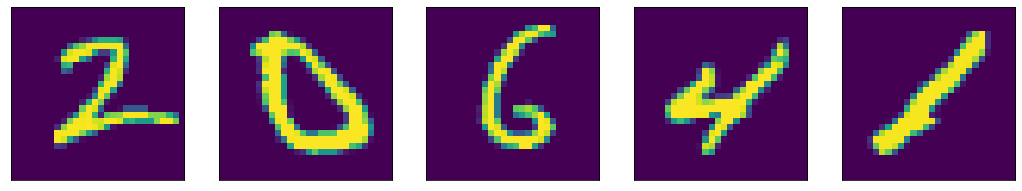

In [42]:
plt.figure(figsize = (18, 18)) # define o tamanho do grafico
# Agora vamos ir fazendo o gráfico por partes
for i, indice_imagem in enumerate(imagens_teste):
    eixo = plt.subplot(1, # Linhas
                       5,  # Colunas
                       i + 1) # retorna um subgráfico 
    plt.imshow(X_train[indice_imagem].reshape(28, 28))
    plt.xticks(()) # retira as medidas do eixo X
    plt.yticks(()) # retira as medidas do eixo Y
    

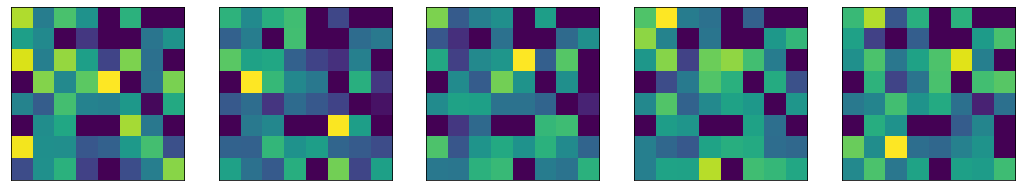

In [43]:
plt.figure(figsize = (18, 18)) # define o tamanho do grafico
# Agora vamos ir fazendo o gráfico por partes
for i, indice_imagem in enumerate(imagens_teste):
    eixo = plt.subplot(1, # Linhas
                       5,  # Colunas
                       i + 1) # retorna um subgráfico 
    plt.imshow(imagens_codificadas[indice_imagem].reshape(8, 8))
    plt.xticks(()) # retira as medidas do eixo X
    plt.yticks(()) # retira as medidas do eixo Y
    

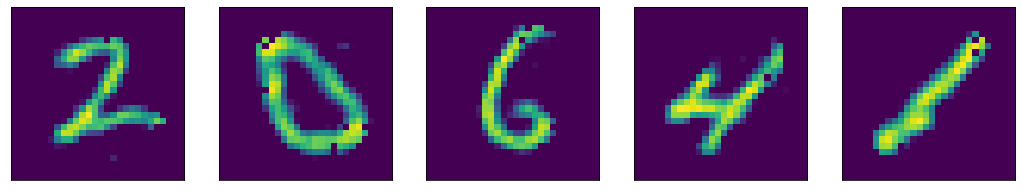

In [44]:
plt.figure(figsize = (18, 18)) # define o tamanho do grafico
# Agora vamos ir fazendo o gráfico por partes
for i, indice_imagem in enumerate(imagens_teste):
    eixo = plt.subplot(1, # Linhas
                       5,  # Colunas
                       i + 1) # retorna um subgráfico 
    plt.imshow(imagens_decodificadas[indice_imagem].reshape(28, 28))
    plt.xticks(()) # retira as medidas do eixo X
    plt.yticks(()) # retira as medidas do eixo Y
    

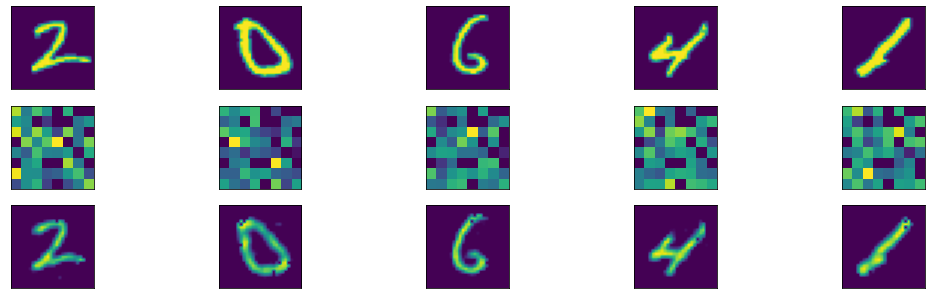

In [47]:
# Fazendo o gráfico com todas as etapas
plt.figure(figsize = (18, 18)) # define o tamanho do grafico
for i, indice_imagem in enumerate(imagens_teste):
    
    eixo = plt.subplot(10, # Linhas
                       5, # Colunas
                       i + 1) # retorna um subgráfico
    
    plt.imshow(X_train[indice_imagem].reshape(28, 28))
    plt.xticks(()) # retira as medidas do eixo X
    plt.yticks(()) # retira as medidas do eixo Y
    
    eixo = plt.subplot(10, 5, i + 1 + numero_imagens)
    plt.imshow(imagens_codificadas[indice_imagem].reshape(8, 8))
    plt.xticks(()) # retira as medidas do eixo X
    plt.yticks(()) # retira as medidas do eixo Y
    
    eixo = plt.subplot(10, 5, i + 1 + numero_imagens * 2)
    plt.imshow(imagens_decodificadas[indice_imagem].reshape(28, 28))
    plt.xticks(()) # retira as medidas do eixo X
    plt.yticks(()) # retira as medidas do eixo Y
    